In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
penguins = sns.load_dataset('penguins')
penguins.fillna(method='backfill', inplace=True)
X = penguins.drop('species', axis=1)
y = penguins['species']
X.replace(['Torgersen', 'Biscoe', 'Dream'], [0, 1, 2], inplace=True)
y.replace(['Adelie', 'Chinstrap', 'Gentoo'], [0, 1, 2], inplace=True)
X.drop('sex', axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, train_size=0.8, test_size=0.2)

In [22]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model

KNeighborsClassifier()

In [23]:
model.fit(X_train, y_train)
y_model = model.predict(X_test)
accuracy_score(y_test, y_model)

0.8260869565217391

In [24]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X, y, cv=5)
# 5 different model etstimations
# repeating the validation across different subsets of the data gives an even better idea of the performance of the algorithm

array([0.72463768, 0.79710145, 0.72463768, 0.82608696, 0.89705882])

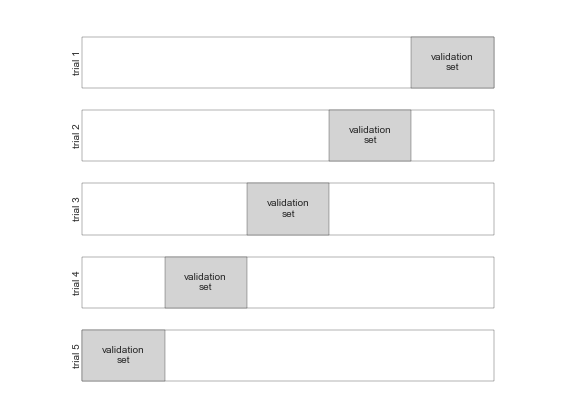

In [25]:
scores = cross_val_score(model, X, y, cv=10)
scores

array([0.74285714, 0.82857143, 0.71428571, 0.74285714, 0.64705882,
       0.76470588, 0.88235294, 0.79411765, 0.91176471, 0.85294118])

In [26]:
scores.mean()

0.7881512605042016

In [27]:
# leave-one-out cross validation
# the number of folds is equal to the number of data points
from sklearn.model_selection import LeaveOneOut

scores = cross_val_score(model, X, y, cv=LeaveOneOut())
scores.shape

(344,)

In [28]:
scores.mean()

0.8081395348837209

In [29]:
# in practice, models tend to have many hyperparameters 
# and our task is simply to find the model whose estimate of accuracy is maximal
# scikit-Learn provides automated tools to do this in the grid search module
from sklearn.model_selection import GridSearchCV

# just random knn parameters 
param_grid = {'n_neighbors': [5, 10, 30],
              'weights': ['uniform', 'distance'],
              'leaf_size': [1, 3, 10, 30, 45],
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

# setting the grid 
grid = GridSearchCV(model, param_grid, cv=5)
grid

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'leaf_size': [1, 3, 10, 30, 45],
                         'n_neighbors': [5, 10, 30],
                         'weights': ['uniform', 'distance']})

In [30]:
# now enumerate and train each model
grid.fit(X, y)
# print the best one
grid.best_params_

{'algorithm': 'ball_tree',
 'leaf_size': 1,
 'n_neighbors': 5,
 'weights': 'distance'}

In [31]:
# finally, use the best model 
model = grid.best_estimator_
model

KNeighborsClassifier(algorithm='ball_tree', leaf_size=1, weights='distance')

In [32]:
# full list of params
grid.best_estimator_.get_params()

{'algorithm': 'ball_tree',
 'leaf_size': 1,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'distance'}

In [33]:
X

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0,39.1,18.7,181.0,3750.0
1,0,39.5,17.4,186.0,3800.0
2,0,40.3,18.0,195.0,3250.0
3,0,36.7,19.3,193.0,3450.0
4,0,36.7,19.3,193.0,3450.0
...,...,...,...,...,...
339,1,46.8,14.3,215.0,4850.0
340,1,46.8,14.3,215.0,4850.0
341,1,50.4,15.7,222.0,5750.0
342,1,45.2,14.8,212.0,5200.0


In [34]:
# pipelines are a simple way to keep data preprocessing and modeling code organized
# a pipeline bundles preprocessing and modeling steps so you can use the whole bundle as if it were a single step
from sklearn.pipeline import Pipeline
# suppose I want to scaling all my data in the interval [0,1]
# i'll import scaler
from sklearn.preprocessing import MinMaxScaler

# and now I want all the data coming into my model to be automatically scaled using MinMaxScaler
pipeline = Pipeline([
    ('scaler', MinMaxScaler()), # scaling
    ('model', model) # using my model
])

# training pipeline
pipeline.fit(X_train, y_train)

# now the pipeline is a model.

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=1,
                                      weights='distance'))])

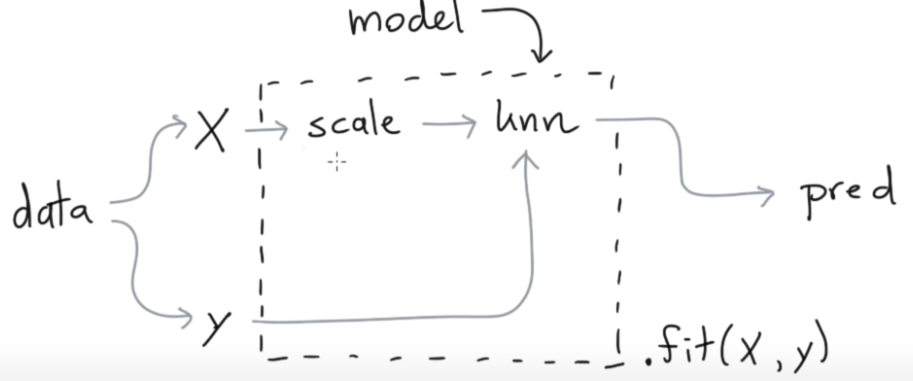

In [35]:
# now combine the grid with the pipeline

knn = KNeighborsClassifier()

pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', knn)
])

# possible pipeline parameters
# old parameters are distinguished by the prefix 'model__', indicating that they belong to the knn
pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('model', KNeighborsClassifier())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': KNeighborsClassifier(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__algorithm': 'auto',
 'model__leaf_size': 30,
 'model__metric': 'minkowski',
 'model__metric_params': None,
 'model__n_jobs': None,
 'model__n_neighbors': 5,
 'model__p': 2,
 'model__weights': 'uniform'}

In [36]:
# grid for pipeline
param_grid = {'model__n_neighbors': [5, 10, 30],
              'model__weights': ['uniform', 'distance'],
              'model__leaf_size': [1, 3, 10, 30, 45],
              'model__algorithm': ['ball_tree', 'kd_tree', 'brute']}

grid = GridSearchCV(pipeline, param_grid) # now estimator is the pipeline
grid

GridSearchCV(estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('model', KNeighborsClassifier())]),
             param_grid={'model__algorithm': ['ball_tree', 'kd_tree', 'brute'],
                         'model__leaf_size': [1, 3, 10, 30, 45],
                         'model__n_neighbors': [5, 10, 30],
                         'model__weights': ['uniform', 'distance']})

In [37]:
grid.fit(X, y)
# what we have done now is to perform 5 validations using cross validation, 
# by going through each parameter of the grid, pre-scaling the raw data to [0,1]
# and when I say 'by going through each parameter' I really mean that GridSearch went through all the possible combinations
# this can well be seen by using the parameter
grid.cv_results_

{'mean_fit_time': array([0.00278573, 0.00328412, 0.0021214 , 0.00258465, 0.00219736,
        0.00234046, 0.0024159 , 0.00208321, 0.00208921, 0.00213728,
        0.00209823, 0.00217104, 0.00204997, 0.00205503, 0.00219355,
        0.00209451, 0.00205832, 0.002104  , 0.00210934, 0.00207033,
        0.00205593, 0.00210962, 0.00205221, 0.00205178, 0.00205069,
        0.00252962, 0.00207009, 0.00231075, 0.00215926, 0.00204849,
        0.00224347, 0.0023283 , 0.00217257, 0.00218158, 0.00218425,
        0.00218801, 0.00211706, 0.0021215 , 0.00227757, 0.00217042,
        0.00231371, 0.00280128, 0.00324912, 0.00338111, 0.00295863,
        0.00282102, 0.00282221, 0.00271859, 0.00353141, 0.0025135 ,
        0.00252213, 0.00270357, 0.00257568, 0.00268035, 0.00250063,
        0.0025034 , 0.00268555, 0.00254107, 0.00209012, 0.00205631,
        0.00207186, 0.00245109, 0.00199733, 0.00203023, 0.0021687 ,
        0.00192399, 0.00199137, 0.00193219, 0.00201855, 0.00196481,
        0.00195947, 0.00196853,

In [38]:
new_model = grid.best_estimator_
new_model

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 KNeighborsClassifier(algorithm='ball_tree', leaf_size=1,
                                      n_neighbors=10))])

In [39]:
# let's compare the new predictions with those at the beginning
knn.fit(X_train, y_train)
new_model.fit(X_train, y_train)
print('Before:', accuracy_score(y_test, knn.predict(X_test)))
print('After:', accuracy_score(y_test, new_model.predict(X_test)))

Before: 0.8260869565217391
After: 0.9855072463768116
